In [1]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse
from regions import Regions, PixCoord
from astropy import stats
from itertools import chain
from radio_beam import Beams
from astropy.convolution import convolve
import Paths.Paths as paths
Path = paths.filepaths()



In [2]:
from astropy.table import Table
import matplotlib as mpl
import astropy.constants as c
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.modeling.models import BlackBody
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)


def get_noise(fitsfile, noiseregion):
    fitsdata = fits.open(b6data)
    image = fitsdata[0].data
    if len(image.shape)!=2:
        image = image[0][0] 
    hdrNB = fits.getheader(fitsfile)  
    wcsNB = WCS(hdrNB,naxis=2)
    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcsNB)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = stats.mad_std(noiseim,ignore_nan=True)

    return std
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)
def get_S_thin(T_thin, surf_den_H_2, freq, r_thick,size):
    d = 5.41 * u.kpc
    radius = size * u.AU
    
    kappa_ = kappa(freq)
    
    avg_gas_mass = 2.8 * c.u
    surf_den = surf_den_H_2 * avg_gas_mass
    F_nu = np.pi * 2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled)))
    
    S_nu_hole = (F_nu / np.pi) * ((np.pi * radius**2) - (np.pi * r_thick**2)) / d**2
    
    return S_nu_hole.to(u.mJy)

def thick_bb_emission(T, freq, radii):
    B_nu = (2 * freq**3 *c.h / (c.c**2) * 1 / (np.e**(c.h*freq/(c.k_B*T))-1)).to(u.W/u.m**2/u.Hz)
    d = 8.4 * u.kpc
    S_nu = B_nu * np.pi * radii**2 / d**2 
    
    return S_nu.to(u.mJy)

def total_emission(T_thin, T_thick, freq, surf_den, r_thick, r_total):
    flux = np.zeros((len(r_thick),len(surf_den)))
    for i,r in enumerate(r_thick):
        for j,den in enumerate(surf_den):
            flux[i,j] =  get_S_thin(T_thin, surf_den, freq, r_thick,r_total)+thick_bb_emission(T_thick, freq, r_thick)
    return flux
def get_bb_intensity(freq, surf_den,T_thin):
    
    kappa_ = kappa(freq)
    
    I_nu =  2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled))) /u.sr
    
    
    
    return I_nu.to(u.Jy/u.arcsec**2)

def flux_gaussian_multiple_apertures(flux, major, minor, major_corr, minor_corr): # major, minor in sigma
    flux_rarr =flux * (1 - np.exp(-major_corr*minor_corr/2/major/minor))
    return flux_rarr

            
       
hdrNB6 = fits.getheader(Path.w51e_b6_cont)  
my_beamNB6 = Beam.from_fits_header(hdrNB6)
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)
my_beamNB3 = Beam.from_fits_header(hdrNB3)
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)
r_max = np.sqrt(my_beamNB3.major/2*my_beamNB3.minor/2) * np.pi/180* 5.41*1000*206265
r_max = r_max.value
T_thin = 50 * u.K
T_thick = 50 * u.K
freq93 = 92.98 * u.GHz
freq225 = 226.69 * u.GHz

r_min = 1 # AU
#r_max = 713/2 # AU
r_thick = np.linspace(r_min, r_max, 1000) * u.AU
avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+21 / u.cm**2
H_2_den_max = 1e+27 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2

b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K)
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)

b3flux_50 = get_bb_intensity(freq93, surf_den, 50*u.K)
b6flux_50 = get_bb_intensity(freq225, surf_den, 50*u.K)

b3flux_100 = get_bb_intensity(freq93, surf_den, 100*u.K)
b6flux_100 = get_bb_intensity(freq225, surf_den, 100*u.K)

b3flux_200 = get_bb_intensity(freq93, surf_den, 200*u.K)
b6flux_200 = get_bb_intensity(freq225, surf_den, 200*u.K)

b3flux_500 = get_bb_intensity(freq93, surf_den, 500*u.K)
b6flux_500 = get_bb_intensity(freq225, surf_den, 500*u.K)


"""
w51e_b3noise = get_noise(w51e_b3_tt0,w51e_b3_noiseregion)
w51e_b6noise = get_noise(w51e_b6,w51e_b3_noiseregion)
w51n_b3noise = get_noise(w51e_b3_tt0,w51e_b3_noiseregion)
w51n_b6noise = get_noise(w51e_b3_tt0,w51e_b3_noiseregion)
"""


w51e_catalog = Table.read(Path.w51e_dendro_matched_catalog) 
w51n_catalog = Table.read(Path.w51n_dendro_matched_catalog) 

w51e_peak_flux_b3 = w51e_catalog['flux_peak_b3']
w51e_peak_flux_b6 = w51e_catalog['flux_peak_b6']
w51n_peak_flux_b3 = w51n_catalog['flux_peak_b3']
w51n_peak_flux_b6 = w51n_catalog['flux_peak_b6']

w51e_b3_flux_fits = Table.read(Path.w51e_b3_flux)
w51e_b6_flux_fits = Table.read(Path.w51e_b6_flux)
w51n_b3_flux_fits = Table.read(Path.w51n_b3_flux)
w51n_b6_flux_fits = Table.read(Path.w51n_b6_flux)
w51e_b6_flux_conv_fits = Table.read(Path.w51e_b6_conv_flux)
w51n_b6_flux_conv_fits = Table.read(Path.w51n_b6_conv_flux)

w51e_b3_major = w51e_b3_flux_fits['deconvolved_major']
w51e_b6_major = w51e_b6_flux_conv_fits['deconvolved_major'] #FWHM, deg
w51n_b3_major = w51n_b3_flux_fits['deconvolved_major']
w51n_b6_major = w51n_b6_flux_conv_fits['deconvolved_major']
w51e_b3_minor = w51e_b3_flux_fits['deconvolved_minor']
w51e_b6_minor = w51e_b6_flux_conv_fits['deconvolved_minor']
w51n_b3_minor = w51n_b3_flux_fits['deconvolved_minor']
w51n_b6_minor = w51n_b6_flux_conv_fits['deconvolved_minor']


"""
w51e_b3_major_upperr = w51e_b3_flux_fits['deconvolved_major_upperr']
w51e_b6_major_upperr = w51e_b6_flux_fits['deconvolved_major_upperr']
w51n_b3_major_upperr = w51n_b3_flux_fits['deconvolved_major_upperr']
w51n_b6_major_upperr = w51n_b6_flux_fits['deconvolved_major_upperr']
w51e_b3_minor_upperr = w51e_b3_flux_fits['deconvolved_minor_upperr']
w51e_b6_minor_upperr = w51e_b6_flux_fits['deconvolved_minor_upperr']
w51n_b3_minor_upperr = w51n_b3_flux_fits['deconvolved_minor_upperr']
w51n_b6_minor_upperr = w51n_b6_flux_fits['deconvolved_minor_upperr']

w51e_b3_major_lowerr = w51e_b3_flux_fits['deconvolved_major_lowerr']
w51e_b6_major_lowerr = w51e_b6_flux_fits['deconvolved_major_lowerr']
w51n_b3_major_lowerr = w51n_b3_flux_fits['deconvolved_major_lowerr']
w51n_b6_major_lowerr = w51n_b6_flux_fits['deconvolved_major_lowerr']
w51e_b3_minor_lowerr = w51e_b3_flux_fits['deconvolved_minor_lowerr']
w51e_b6_minor_lowerr = w51e_b6_flux_fits['deconvolved_minor_lowerr']
w51n_b3_minor_lowerr = w51n_b3_flux_fits['deconvolved_minor_lowerr']
w51n_b6_minor_lowerr = w51n_b6_flux_fits['deconvolved_minor_lowerr']
"""
w51e_b3_int_flux = w51e_b3_flux_fits['flux']
w51e_b6_int_flux = w51e_b6_flux_conv_fits['flux']
w51n_b3_int_flux = w51n_b3_flux_fits['flux']
w51n_b6_int_flux = w51n_b6_flux_conv_fits['flux']

#w51e_b3_error_code = w51e_b3_flux_fits['error_code']
#w51e_b6_error_code  = w51e_b6_flux_conv_fits['error_code']
#w51n_b3_error_code  = w51n_b3_flux_fits['error_code']
#w51n_b6_error_code  = w51n_b6_flux_conv_fits['error_code']

scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
sig_to_fwhm = np.sqrt(2*np.log(2))*2
#b6_min_size_maj =sig_to_fwhm*np.sqrt((my_beamNB6.major.value/scaleNB6.value/sig_to_fwhm+0.05)**2 
#                                 - (my_beamNB6.major.value/scaleNB6.value/sig_to_fwhm)**2)*scaleNB6.value
#b6_min_size_min =sig_to_fwhm*np.sqrt((my_beamNB6.minor.value/scaleNB6.value/sig_to_fwhm+0.05)**2 
#                                 - (my_beamNB6.minor.value/scaleNB6.value/sig_to_fwhm)**2)*scaleNB6.value

#b3_min_size_maj =sig_to_fwhm*np.sqrt((my_beamNB3.major.value/scaleNB3.value/sig_to_fwhm+0.05)**2 
#                                 - (my_beamNB3.major.value/scaleNB3.value/sig_to_fwhm)**2)*scaleNB3.value
#b3_min_size_min =sig_to_fwhm*np.sqrt((my_beamNB3.minor.value/scaleNB3.value/sig_to_fwhm+0.05)**2 
#                                 - (my_beamNB3.minor.value/scaleNB3.value/sig_to_fwhm)**2)*scaleNB3.value



w51e_b3_int_flux[w51e_b3_int_flux<0]=np.nan
w51n_b3_int_flux[w51n_b3_int_flux<0]=np.nan
w51e_b6_int_flux[w51e_b6_int_flux<0]=np.nan
w51n_b6_int_flux[w51n_b6_int_flux<0]=np.nan

w51e_b3_unresolved = np.logical_and(w51e_b3_major<=0, np.isfinite(w51e_b3_int_flux))
w51n_b3_unresolved = np.logical_and(w51n_b3_major<=0, np.isfinite(w51n_b3_int_flux))
w51e_b6_unresolved = np.logical_and(w51e_b6_major<=0, np.isfinite(w51e_b6_int_flux))
w51n_b6_unresolved = np.logical_and(w51n_b6_major<=0, np.isfinite(w51n_b6_int_flux))


w51e_b3_resolved = np.logical_and(w51e_b3_major>0, np.isfinite(w51e_b3_int_flux))
w51n_b3_resolved = np.logical_and(w51n_b3_major>0, np.isfinite(w51n_b3_int_flux))
w51e_b6_resolved = np.logical_and(w51e_b6_major>0, np.isfinite(w51e_b6_int_flux))
w51n_b6_resolved = np.logical_and(w51n_b6_major>0, np.isfinite(w51n_b6_int_flux))

w51e_b3_res_b6_res = np.logical_and(w51e_b3_resolved, w51e_b6_resolved)
w51n_b3_res_b6_res = np.logical_and(w51n_b3_resolved, w51n_b6_resolved)
w51e_b3_unres_b6_res = np.logical_and(w51e_b3_unresolved, w51e_b6_resolved)
w51n_b3_unres_b6_res = np.logical_and(w51n_b3_unresolved, w51n_b6_resolved)
w51e_b3_res_b6_unres = np.logical_and(w51e_b3_resolved, w51e_b6_unresolved)
w51n_b3_res_b6_unres = np.logical_and(w51n_b3_resolved, w51n_b6_unresolved)
w51e_b3_unres_b6_unres = np.logical_and(w51e_b3_unresolved, w51e_b6_unresolved)
w51n_b3_unres_b6_unres = np.logical_and(w51n_b3_unresolved, w51n_b6_unresolved)


w51e_b3_major[w51e_b3_major<=0]=np.nan
w51n_b3_major[w51n_b3_major<=0]=np.nan
w51e_b6_major[w51e_b6_major<=0]=np.nan
w51n_b6_major[w51n_b6_major<=0]=np.nan

w51e_b3_minor[w51e_b3_minor<=0]=np.nan
w51n_b3_minor[w51n_b3_minor<=0]=np.nan
w51e_b6_minor[w51e_b6_minor<=0]=np.nan
w51n_b6_minor[w51n_b6_minor<=0]=np.nan


w51e_b3_int_flux_err = w51e_b3_flux_fits['flux_err']
w51e_b6_int_flux_err = w51e_b6_flux_conv_fits['flux_err']
w51n_b3_int_flux_err = w51n_b3_flux_fits['flux_err']
w51n_b6_int_flux_err = w51n_b6_flux_conv_fits['flux_err']


"""
w51e_b3_int_upp_flux[w51e_b3_int_flux<0]=np.nan
w51e_b6_int_upp_flux[w51e_b6_int_flux<0]=np.nan
w51n_b3_int_upp_flux[w51n_b3_int_flux<0]=np.nan
w51n_b6_int_upp_flux[w51n_b6_int_flux<0]=np.nan

w51e_b3_int_low_flux[w51e_b3_int_flux<0]=np.nan
w51e_b6_int_low_flux[w51e_b6_int_flux<0]=np.nan
w51n_b3_int_low_flux[w51n_b3_int_flux<0]=np.nan
w51n_b6_int_low_flux[w51n_b6_int_flux<0]=np.nan
"""

w51e_b3_err = 2.065537678896079e-05
w51e_b6_err = 0.00012361802520203196
w51n_b3_err = 2.220660593897177e-05
w51n_b6_err = 8.95845803518789e-05


"""
w51e_b3_avg_size = np.sqrt(w51e_b3_major/2 * w51e_b3_minor/2) * np.pi/180 * 5.41*1000*206265
w51e_b6_avg_size = np.sqrt(w51e_b6_major/2 * w51e_b6_minor/2) * np.pi/180 * 5.41*1000*206265
w51n_b3_avg_size = np.sqrt(w51n_b3_major/2 * w51n_b3_minor/2) * np.pi/180 * 5.1*1000*206265
w51n_b6_avg_size = np.sqrt(w51n_b6_major/2 * w51n_b6_minor/2) * np.pi/180 * 5.1*1000*206265
"""
def arcsec_to_au(dist=5.41):
    #dist in kpc
    return 2 /2.355 * np.pi/180 * dist*1000*206265

    
#w51e_b3_avg_size = np.array([np.max((w51e_b3_major[i], w51e_b3_minor[i])) for i in range(len(w51e_b3_major.value))]) * arcsec_to_au() 
#w51e_b6_avg_size = np.array([np.max((w51e_b6_major[i], w51e_b6_minor[i])) for i in range(len(w51e_b6_major.value))]) * arcsec_to_au()
#w51n_b3_avg_size = np.array([np.max((w51n_b3_major[i], w51n_b3_minor[i])) for i in range(len(w51n_b3_major.value))]) * arcsec_to_au(dist=5.1)
#w51n_b6_avg_size = np.array([np.max((w51n_b6_major[i], w51n_b6_minor[i])) for i in range(len(w51n_b6_major.value))]) * arcsec_to_au(dist=5.1)

w51e_b3_avg_size_major = w51e_b3_major * arcsec_to_au()
w51e_b6_avg_size_major = w51e_b6_major * arcsec_to_au()
w51n_b3_avg_size_major = w51n_b3_major * arcsec_to_au()
w51n_b6_avg_size_major = w51n_b6_major * arcsec_to_au()

w51e_b3_avg_size_minor = w51e_b3_major * arcsec_to_au()
w51e_b6_avg_size_minor = w51e_b6_major * arcsec_to_au()
w51n_b3_avg_size_minor = w51n_b3_major * arcsec_to_au()
w51n_b6_avg_size_minor = w51n_b6_major * arcsec_to_au()


print(np.nanmin(w51e_b3_avg_size_major), np.nanmin(w51e_b6_avg_size_major), np.nanmin(w51n_b3_avg_size_major), np.nanmin(w51n_b6_avg_size_major))
print(np.nanmin(w51e_b3_avg_size_minor), np.nanmin(w51e_b6_avg_size_minor), np.nanmin(w51n_b3_avg_size_minor), np.nanmin(w51n_b6_avg_size_minor))
w51e_b3_avg_size_major[w51e_b3_unresolved] = np.nanmin(w51e_b3_avg_size_major)
w51e_b6_avg_size_major[w51e_b6_unresolved] = np.nanmin(w51e_b6_avg_size_major)
w51n_b3_avg_size_major[w51n_b3_unresolved] = np.nanmin(w51n_b3_avg_size_major)
w51n_b6_avg_size_major[w51n_b6_unresolved] = np.nanmin(w51n_b6_avg_size_major)

w51e_b3_avg_size_minor[w51e_b3_unresolved] = np.nanmin(w51e_b3_avg_size_minor)
w51e_b6_avg_size_minor[w51e_b6_unresolved] = np.nanmin(w51e_b6_avg_size_minor)
w51n_b3_avg_size_major[w51n_b3_unresolved] = np.nanmin(w51n_b3_avg_size_minor)
w51n_b6_avg_size_major[w51n_b6_unresolved] = np.nanmin(w51n_b6_avg_size_minor)

w51e_b3_major[w51e_b3_unresolved] = np.nanmin(w51e_b3_avg_size_major)/arcsec_to_au()
w51e_b6_major[w51e_b6_unresolved] = np.nanmin(w51e_b6_avg_size_major)/arcsec_to_au()
w51e_b3_minor[w51e_b3_unresolved] = np.nanmin(w51e_b3_avg_size_minor)/arcsec_to_au()
w51e_b6_minor[w51e_b6_unresolved] = np.nanmin(w51e_b6_avg_size_minor)/arcsec_to_au()

w51n_b3_major[w51n_b3_unresolved] = np.nanmin(w51n_b3_avg_size_major)/arcsec_to_au()
w51n_b6_major[w51n_b6_unresolved] = np.nanmin(w51n_b6_avg_size_major)/arcsec_to_au()
w51n_b3_minor[w51n_b3_unresolved] = np.nanmin(w51n_b3_avg_size_minor)/arcsec_to_au()
w51n_b6_minor[w51n_b6_unresolved] = np.nanmin(w51n_b6_avg_size_minor)/arcsec_to_au()

w51e_b3_flux_rescaled = w51e_b3_int_flux * (1-np.exp(-(2/2.355)**2*8*np.log(2)))                                      
w51e_b6_flux_rescaled = flux_gaussian_multiple_apertures(w51e_b6_int_flux, w51e_b3_major/np.sqrt(8*np.log(2)), w51e_b3_minor/np.sqrt(8*np.log(2)), 
                                                         w51e_b3_major*2/2.355, w51e_b3_minor*2/2.355)

w51n_b3_flux_rescaled = w51n_b3_int_flux * (1-np.exp(-(2/2.355)**2*8*np.log(2)))
w51n_b6_flux_rescaled = flux_gaussian_multiple_apertures(w51n_b6_int_flux, w51n_b3_major/np.sqrt(8*np.log(2)), w51n_b3_minor/np.sqrt(8*np.log(2)), 
                                                         w51n_b3_major*2/2.355, w51n_b3_minor*2/2.355)

w51e_b3_flux_err_rescaled = w51e_b3_int_flux_err * (1-np.exp(-(2/2.355)**2*8*np.log(2)))                                      
w51e_b6_flux_err_rescaled = flux_gaussian_multiple_apertures(w51e_b6_int_flux_err, w51e_b3_major/np.sqrt(8*np.log(2)), w51e_b3_minor/np.sqrt(8*np.log(2)), 
                                                         w51e_b3_major*2/2.355, w51e_b3_minor*2/2.355)
w51n_b3_flux_err_rescaled = w51n_b3_int_flux_err * (1-np.exp(-(2/2.355)**2*8*np.log(2)))
w51n_b6_flux_err_rescaled = flux_gaussian_multiple_apertures(w51n_b6_int_flux_err, w51n_b3_major/np.sqrt(8*np.log(2)), w51n_b3_minor/np.sqrt(8*np.log(2)), 
                                                         w51n_b3_major*2/2.355, w51n_b3_minor*2/2.355)

angular_size_in_sky_w51e_b3 = 2*w51e_b3_avg_size_major / 5400  * u.arcsec # au / pc -> arcsec, radius x 2
angular_size_in_sky_w51e_b6 = 2*w51e_b6_avg_size_major/ 5400* u.arcsec 
angular_size_in_sky_w51n_b3 = 2*w51n_b3_avg_size_major / 5400* u.arcsec 
angular_size_in_sky_w51n_b6 = 2*w51n_b6_avg_size_major / 5400* u.arcsec 



# keep same size (b3 size)
w51e_b3_flux_rescaled_int = w51e_b3_flux_rescaled / angular_size_in_sky_w51e_b3 **2  #Jy/arcsec**2
w51e_b6_flux_rescaled_int = w51e_b6_flux_rescaled / angular_size_in_sky_w51e_b6 **2
w51n_b3_flux_rescaled_int = w51n_b3_flux_rescaled / angular_size_in_sky_w51n_b3 **2
w51n_b6_flux_rescaled_int = w51n_b6_flux_rescaled / angular_size_in_sky_w51n_b6 **2


#print(w51e_b3_flux_rescaled.to(u.Jy), w51e_b6_flux_rescaled.to(u.Jy))
print('hoho',w51e_b3_flux_rescaled_int)


#print(w51n_b3_flux_rescaled_int, w51n_b6_flux_rescaled_int)

w51e_b3_flux_err_rescaled_int = w51e_b3_flux_err_rescaled / angular_size_in_sky_w51e_b3 **2
w51e_b6_flux_err_rescaled_int = w51e_b6_flux_err_rescaled / angular_size_in_sky_w51e_b6 **2
w51n_b3_flux_err_rescaled_int = w51n_b3_flux_err_rescaled / angular_size_in_sky_w51n_b3 **2
w51n_b6_flux_err_rescaled_int = w51n_b6_flux_err_rescaled / angular_size_in_sky_w51n_b6 **2

#w51e_snrind = np.where((w51e_peak_flux_b3>3*w51e_b3_err)&(w51e_peak_flux_b6>3*w51e_b6_err)&(w51e_b3_snr_major>3)&(w51e_b6_snr_major>3)&(w51e_b3_snr_minor>3)&(w51e_b6_snr_minor>3))[0]
#w51n_snrind = np.where((w51n_peak_flux_b3>3*w51n_b3_err)&(w51n_peak_flux_b6>3*w51n_b6_err)&(w51n_b3_snr_major>3)&(w51n_b6_snr_major>3)&(w51n_b3_snr_minor>3)&(w51n_b6_snr_minor>3))[0]
"""
for i in range(len(w51e_b3_major)):
    print(i, w51e_catalog['is_matched'][i],'%3.2e'%w51e_b3_flux_rescaled_int.value[i], '%3.2e'%w51e_b6_flux_rescaled_int.value[i], w51e_b3_avg_size[i], w51e_b6_avg_size[i], w51e_b3_error_code[i], w51e_b6_error_code[i])
for i in range(len(w51n_b3_major)):
    print(i, w51n_catalog['is_matched'][i],'%3.2e'%w51n_b3_flux_rescaled_int.value[i], '%3.2e'%w51n_b6_flux_rescaled_int.value[i], w51n_b3_avg_size[i], w51n_b6_avg_size[i], w51n_b3_error_code[i], w51n_b6_error_code[i])
"""   
    



287.21460675968945 290.7458829426607 229.34868580833958 333.37683520080805
287.21460675968945 290.7458829426607 229.34868580833958 333.37683520080805
hoho         flux        
         Jy         
--------------------
 0.05173619528658114
 0.11709370698492516
  0.0483895297402313
  0.0206825343637696
 0.16860423221360848
 0.03263844225846465
0.026338577535870992
 0.15452749733669421
 0.30030156648945605
 0.24420105178422571
                 ...
 0.05077587640926576
0.033009596858953195
  0.0745035250969444
 0.03360229002031707
 0.05098389337330999
0.025267001641948072
0.038360158884452766
0.055081466398130746
  0.0466161302418355
0.020125242996011466
Length = 128 rows


"\nfor i in range(len(w51e_b3_major)):\n    print(i, w51e_catalog['is_matched'][i],'%3.2e'%w51e_b3_flux_rescaled_int.value[i], '%3.2e'%w51e_b6_flux_rescaled_int.value[i], w51e_b3_avg_size[i], w51e_b6_avg_size[i], w51e_b3_error_code[i], w51e_b6_error_code[i])\nfor i in range(len(w51n_b3_major)):\n    print(i, w51n_catalog['is_matched'][i],'%3.2e'%w51n_b3_flux_rescaled_int.value[i], '%3.2e'%w51n_b6_flux_rescaled_int.value[i], w51n_b3_avg_size[i], w51n_b6_avg_size[i], w51n_b3_error_code[i], w51n_b6_error_code[i])\n"

In [3]:
def make_temp_hist2(b3flux, b6flux, surf_den, temparr, b3freq, b6freq, index, plot=False, ):
    # dist in pc
    temp_yso_arr = []
   
    for i in range(len(b3flux)):
        if i in index:
            if not np.isfinite(b3flux[i]):
                temp_yso_arr.append(np.nan)
                continue
            if not np.isfinite(b6flux[i]):
                temp_yso_arr.append(np.nan)
                continue
            
            b6fluxarr = []
            isinsidearr=[]

            for temp in temparr:
                b3flux_bb = get_bb_intensity(b3freq, surf_den, temp*u.K)
                b6flux_bb = get_bb_intensity(b6freq, surf_den, temp*u.K)
                b3ind = np.searchsorted(b3flux_bb.value, b3flux[i])
                if b3ind==len(surf_den):
                    b3ind = len(surf_den)-1
                    isinsidearr.append(False)
                else:
                    isinsidearr.append(True)
                b6flux_inbetween = b6flux_bb[b3ind].value
                b6fluxarr.append(b6flux_inbetween)


            tempind = np.searchsorted(b6fluxarr, b6flux[i])
            if tempind==len(b6fluxarr):
                tempind = len(b6fluxarr)-1
            if not isinsidearr[tempind]:
                temp_yso=np.nan
            else:
                if tempind>=len(b6fluxarr)-1:
                    weight=0
                else:
                    weight = (b6flux[i] - b6fluxarr[tempind])/(b6fluxarr[tempind+1] - b6fluxarr[tempind])

                temp_yso = temparr[tempind] + weight
        else:
            temp_yso = np.nan
            
        print(i, b3flux[i], b6flux[i], temp_yso) 
        temp_yso_arr.append(temp_yso)
    return np.array(temp_yso_arr)

In [4]:
temparr = np.arange(1,5000,step=1)

temp_yso_arr_w51e = make_temp_hist2(w51e_b3_flux_rescaled_int.value, w51e_b6_flux_rescaled_int.value, surf_den, temparr, freq93, freq225, np.arange(len(w51e_b3_flux_rescaled_int)))
temp_yso_arr_w51n = make_temp_hist2(w51n_b3_flux_rescaled_int.value, w51n_b6_flux_rescaled_int.value, surf_den, temparr, freq93, freq225, np.arange(len(w51n_b3_flux_rescaled_int)))



0 0.05173619528658114 0.5170190255458942 19.481005906134477
1 0.11709370698492516 0.4123345504495006 nan
2 0.0483895297402313 0.1710813983510018 nan
3 0.0206825343637696 0.4137686437393261 28.94560690297382
4 0.16860423221360848 2.041819745321421 64.19536951475153
5 0.03263844225846465 0.3269891657610685 14.118435031295672
6 0.026338577535870992 0.11665738460390165 7.276462397729649
7 0.15452749733669421 0.177063343006306 nan
8 0.30030156648945605 2.0886684424232214 61.58296595786414
9 0.24420105178422571 1.0083437888372864 nan
10 0.23137996627003243 1.4778109968593098 45.045982729075426
11 0.06566562407859766 0.8334962944921893 30.160905772253148
12 0.1224102859361989 0.2732211861986741 nan
13 0.058376013302196585 0.2815070678907333 12.232058468366933
14 0.03506502386712439 0.25511882065008185 11.557233049052135
15 0.075757962306258 0.5784348484126492 20.64335237725118
16 0.02479850134566057 0.21729739888408597 10.68203502389088
17 0.08223973113861517 0.3305757884884642 nan
18 0.03092

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[19.48100591         nan         nan 28.9456069  64.19536951 14.11843503
  7.2764624          nan 61.58296596         nan 45.04598273 30.16090577
         nan 12.23205847 11.55723305 20.64335238 10.68203502         nan
 36.74132874         nan         nan 13.52674906 14.10741441         nan
 18.57514912         nan 28.0831175  41.54058106         nan         nan
         nan 44.80216197 30.76840617         nan         nan  8.28762565
 18.79501661         nan 21.91911804 12.4117338          nan         nan
  7.80383045         nan         nan 14.27767674 24.56887291 14.4312707
         nan  9.85782843 38.9841941          nan         nan 13.36894757
 16.37489695 16.40190227 10.96244513 22.20442557 30.91735417 30.52166851
 13.26719471 23.65998044 27.12432161 13.11397107 12.33718716 45.368336
 12.35446567         nan 18.50478569 11.38187146 21.187585   12.81969216
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

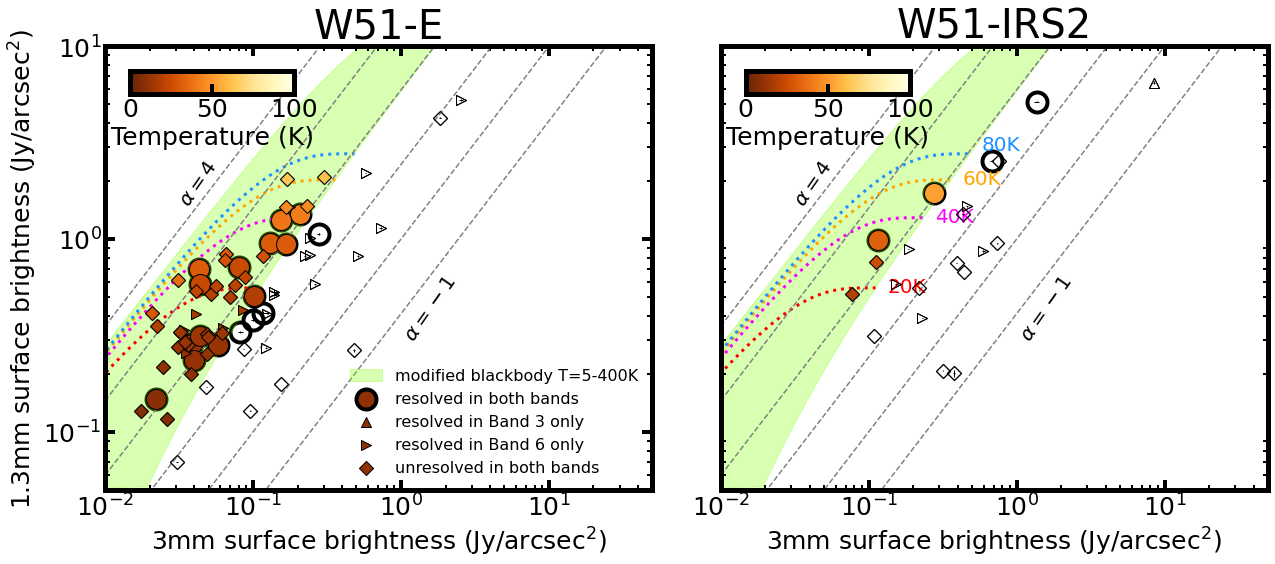

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.cm as cm
from scipy.interpolate import CubicSpline

temp_yso_arr_w51e = np.array(temp_yso_arr_w51e)
temp_yso_arr_w51n = np.array(temp_yso_arr_w51n)
print(temp_yso_arr_w51e)
print(len(np.where(np.isfinite(temp_yso_arr_w51e))[0]), len(temp_yso_arr_w51e))
print(temp_yso_arr_w51n)
print(len(np.where(np.isfinite(temp_yso_arr_w51n))[0]), len(temp_yso_arr_w51n))

#temp_yso_arr_w51e[temp_yso_arr_w51e>500]=np.nan
#temp_yso_arr_w51n[temp_yso_arr_w51n>500]=np.nan

#nonan_w51e = np.where(np.isfinite(temp_yso_arr_w51e))
#nonan_w51n = np.where(np.isfinite(temp_yso_arr_w51n))

#nan_w51e = np.where(~np.isfinite(temp_yso_arr_w51e))
#nan_w51n = np.where(~np.isfinite(temp_yso_arr_w51n))


"""
w51e_b3_flux_rescaled_err_nonan = np.array(list(zip(w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e],
                                              w51e_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e])))
w51e_b3_flux_rescaled_err_nonan = np.array([[w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e]
                                             ,w51e_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e]]]).T

w51e_b6_flux_rescaled_err_nonan = np.array(list(zip(w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e],
                                              w51e_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]))).T
w51e_b6_flux_rescaled_err_nonan = np.array([[w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e]
                                             ,w51e_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]]]).T

w51n_b3_flux_rescaled_err_nonan = np.array(list(zip(w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n],
                                              w51n_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]))).T
w51n_b3_flux_rescaled_err_nonan = np.array([[w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n]
                                             ,w51n_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]]]).T
w51n_b6_flux_rescaled_err_nonan = np.array(list(zip(w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n],
                                              w51n_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]))).T
w51n_b6_flux_rescaled_err_nonan = np.array([[w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n]
                                             ,w51n_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]]]).T


w51e_b3_flux_rescaled_err_nan = np.array(list(zip(w51e_b3_flux_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b3_flux_low_rescaled_int.to(u.Jy).value[nan_w51e],
                                              w51e_b3_flux_upp_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b3_flux_rescaled_int.to(u.Jy).value[nan_w51e]))).T

w51e_b6_flux_rescaled_err_nan = np.array(list(zip(w51e_b6_flux_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b6_flux_low_rescaled_int.to(u.Jy).value[nan_w51e],
                                              w51e_b6_flux_upp_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b6_flux_rescaled_int.to(u.Jy).value[nan_w51e]))).T

w51n_b3_flux_rescaled_err_nan = np.array(list(zip(w51n_b3_flux_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b3_flux_low_rescaled_int.to(u.Jy).value[nan_w51n],
                                              w51n_b3_flux_upp_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b3_flux_rescaled_int.to(u.Jy).value[nan_w51n]))).T

w51n_b6_flux_rescaled_err_nan = np.array(list(zip(w51n_b6_flux_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b6_flux_low_rescaled_int.to(u.Jy).value[nan_w51n],
                                              w51n_b6_flux_upp_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b6_flux_rescaled_int.to(u.Jy).value[nan_w51n]))).T
"""
cmap = sns.color_palette("YlOrBr_r", as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=0, vmax=100, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
color_w51e = np.array([(mapper.to_rgba(v)) for v in temp_yso_arr_w51e])
color_w51n = np.array([(mapper.to_rgba(v)) for v in temp_yso_arr_w51n])

fig = plt.figure(figsize=(19,8))
ax1 = fig.add_axes([0.1,0.15,0.4,0.77])
ax2 = fig.add_axes([0.55,0.15,0.4,0.77])

sc=ax1.scatter(w51e_b3_flux_rescaled_int.to(u.Jy).value, w51e_b6_flux_rescaled_int.to(u.Jy).value,s=0,
              c=temp_yso_arr_w51e,vmin=0,vmax=100,cmap=cmap)

def plot_flux_flux_temp(ax, b3flux, b6flux, b3fluxerr, b6fluxerr, color, idxlist, lws=[4,1,1,1],
                        label='W51-E', markerlist=['o','^', '>', 'D'], sizelist=[20,10,10,10], uplimarr=[False,True,True, True], lolimarr=[False,False,True,True]):
    for idx, marker, size, uplim, lolim, lw in zip(idxlist, markerlist, sizelist, uplimarr, lolimarr, lws):
        for x, y, xerr, yerr, c,  in zip(b3flux[idx], 
                                    b6flux[idx],
                                    b3fluxerr[idx],
                                    b6fluxerr[idx],
                                    color[idx], 
                                   ):
            ax.errorbar(x,y, 
                    xerr=xerr, 
                    yerr=yerr,
                    fmt=marker, c=c, 
                    ecolor='k', elinewidth=1, mec='k',ms=size,zorder=50)
            ax.scatter(x,y, edgecolor='k',lw=lw, marker=marker,zorder=0,s=size**2,c=c)

idxlist_w51e = [w51e_b3_res_b6_res, w51e_b3_res_b6_unres, w51e_b3_unres_b6_res , w51e_b3_unres_b6_unres   ]

plot_flux_flux_temp(ax1, w51e_b3_flux_rescaled_int.to(u.Jy).value, w51e_b6_flux_rescaled_int.to(u.Jy).value, 
                    w51e_b3_flux_err_rescaled_int, w51e_b3_flux_err_rescaled_int, color_w51e, idxlist_w51e,
                        label='W51-E',)
idxlist_w51n = [w51n_b3_res_b6_res, w51n_b3_res_b6_unres, w51n_b3_unres_b6_res , w51n_b3_unres_b6_unres   ]
    
plot_flux_flux_temp(ax2, w51n_b3_flux_rescaled_int.to(u.Jy).value, w51n_b6_flux_rescaled_int.to(u.Jy).value, 
                    w51n_b3_flux_err_rescaled_int, w51n_b3_flux_err_rescaled_int, color_w51n, idxlist_w51n,
                        label='W51-IRS2',)

axins1 = inset_axes(
    ax1,
    width="30%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper left", borderpad=2.5
    )
axins1.xaxis.set_ticks_position("bottom")
axcbr = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[0, 50, 100])
axcbr.set_label('Temperature (K)')
axins2 = inset_axes(
    ax2,
    width="30%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper left",borderpad=2.5
    )
axins2.xaxis.set_ticks_position("bottom")
axcbr = fig.colorbar(sc, cax=axins2, orientation="horizontal", ticks=[0, 50, 100])
axcbr.set_label('Temperature (K)')

"""
b3freq = 92982346121.91989 
b6freq = 226691598706.70853
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=14,c='gray')

ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=14,c='gray')
"""
b3flux_5 = get_bb_intensity(freq93, surf_den, 5*u.K)
b6flux_5 = get_bb_intensity(freq225, surf_den, 5*u.K)

b3flux_lowlimit_curve_over1 = get_bb_intensity(freq93, surf_den[-1], np.arange(2,400,1)*u.K)
b6flux_lowlimit_curve_over1 = get_bb_intensity(freq225, surf_den[-1], np.arange(2,400,1)*u.K)
b3flux_lowlimit_curve = np.concatenate((b3flux_5.value, b3flux_lowlimit_curve_over1.value))
b6flux_lowlimit_curve = np.concatenate((b6flux_5.value, b6flux_lowlimit_curve_over1.value))
b3flux_400 = get_bb_intensity(freq93, surf_den, 400*u.K)
b6flux_400 = get_bb_intensity(freq225, surf_den, 400*u.K)

interp = CubicSpline(b3flux_400.value, b6flux_400.value)

ax1.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3,label='modified blackbody T=5-400K')
ax2.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3)


b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K)
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)

b3flux_40 = get_bb_intensity(freq93, surf_den, 40*u.K)
b6flux_40 = get_bb_intensity(freq225, surf_den, 40*u.K)

b3flux_60 = get_bb_intensity(freq93, surf_den, 60*u.K)
b6flux_60 = get_bb_intensity(freq225, surf_den, 60*u.K)

b3flux_80 = get_bb_intensity(freq93, surf_den, 80*u.K)
b6flux_80 = get_bb_intensity(freq225, surf_den, 80*u.K)

ax1.plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
ax1.plot(b3flux_40, b6flux_40, c='magenta', ls='dotted',lw=3)
ax1.plot(b3flux_60, b6flux_60, c='orange', ls='dotted',lw=3)
ax1.plot(b3flux_80, b6flux_80, c='dodgerblue', ls='dotted',lw=3)

ax2.plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
ax2.plot(b3flux_40, b6flux_40, c='magenta', ls='dotted',lw=3)
ax2.plot(b3flux_60, b6flux_60, c='orange', ls='dotted',lw=3)
ax2.plot(b3flux_80, b6flux_80, c='dodgerblue', ls='dotted',lw=3)
ax2.text(1.2*b3flux_20[-1].value,0.95*b6flux_20[-1].value, '20K', fontsize=20,color='r')
ax2.text(1.2*b3flux_40[-1].value,0.95*b6flux_40[-1].value, '40K', fontsize=20,color='magenta')

ax2.text(1.2*b3flux_60[-1].value,0.95*b6flux_60[-1].value, '60K', fontsize=20,color='orange')
ax2.text(1.2*b3flux_80[-1].value,1.05*b6flux_80[-1].value, '80K', fontsize=20,color='dodgerblue')

#ax1.text(1.5e-3,7e-3,r'$T=100\,{\rm K}$',c='dodgerblue',fontsize=13)
#ax1.text(8e-4,3.5e-3,r'$T=50\,{\rm K}$',c='magenta',fontsize=13)
#ax1.text(3e-4,1e-3,r'$T=20\,{\rm K}$',c='r',fontsize=13)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('3mm surface brightness (Jy/arcsec$^2$)')
ax1.set_ylabel('1.3mm surface brightness (Jy/arcsec$^2$)')
#ax1.set_xlabel(r'$S_{\rm 3mm}$ $({\rm Jy\,arcsec^{-2}})$')
#ax1.set_ylabel(r'$S_{\rm 1.3mm, conv}$ $({\rm Jy\,arcsec^{-2}})$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('3mm surface brightness (Jy/arcsec$^2$)')
#ax2.set_xlabel(r'$S_{\rm 3mm}$ $({\rm Jy\,arcsec^{-2}})$')
#ax2.set_ylabel(r'$S_{\rm int, 1.3mm}$ (Jy)')

ax1.set_title('W51-E', fontsize=40)
ax2.set_title('W51-IRS2', fontsize=40)
ax1.set_xlim(1e-2,5e1)
ax1.set_ylim(5e-2,1e1)
ax2.set_xlim(1e-2,5e1)
ax2.set_ylim(5e-2,1e1)

#ax1.set_xlim(1e9,1e13)
#ax1.set_ylim(1e10,5e12)
#ax2.set_xlim(1e9,1e13)
#ax2.set_ylim(1e10,5e12)
ax2.set_yticks([])
b3freq = 92982346121.91989 
b6freq = 226691598706.70853
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-2,1e2],10**(np.log10([1e-2,1e2]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')
    ax2.plot([1e-2,1e2],10**(np.log10([1e-2,1e2]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')

ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=20**2, lw=4, marker='o',label='resolved in both bands',edgecolor='k')
ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=10**2, lw=1, marker='^',label='resolved in Band 3 only',edgecolor='k') 
ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=10**2, lw=1, marker='>',label='resolved in Band 6 only',edgecolor='k') 
ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=10**2, lw=1, marker='D',label='unresolved in both bands',edgecolor='k') 

ax1.legend(fontsize=16, frameon=False, loc='lower right')
    
    

ax1.text(0.03,1.5,r'$\alpha=4$',rotation=55,fontsize=20)
ax1.text(1,0.3,r'$\alpha=-1$',rotation=55,fontsize=20)
ax2.text(0.03,1.5,r'$\alpha=4$',rotation=55,fontsize=20)
ax2.text(1,0.3,r'$\alpha=-1$',rotation=55,fontsize=20)
plt.savefig('fluxflux_temp.png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[19.48100591         nan         nan 28.9456069  64.19536951 14.11843503
  7.2764624          nan 61.58296596         nan 45.04598273 30.16090577
         nan 12.23205847 11.55723305 20.64335238 10.68203502         nan
 36.74132874         nan         nan 13.52674906 14.10741441         nan
 18.57514912         nan 28.0831175  41.54058106         nan         nan
         nan 44.80216197 30.76840617         nan         nan  8.28762565
 18.79501661         nan 21.91911804 12.4117338          nan         nan
  7.80383045         nan         nan 14.27767674 24.56887291 14.4312707
         nan  9.85782843 38.9841941          nan         nan 13.36894757
 16.37489695 16.40190227 10.96244513 22.20442557 30.91735417 30.52166851
 13.26719471 23.65998044 27.12432161 13.11397107 12.33718716 45.368336
 12.35446567         nan 18.50478569 11.38187146 21.187585   12.81969216
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

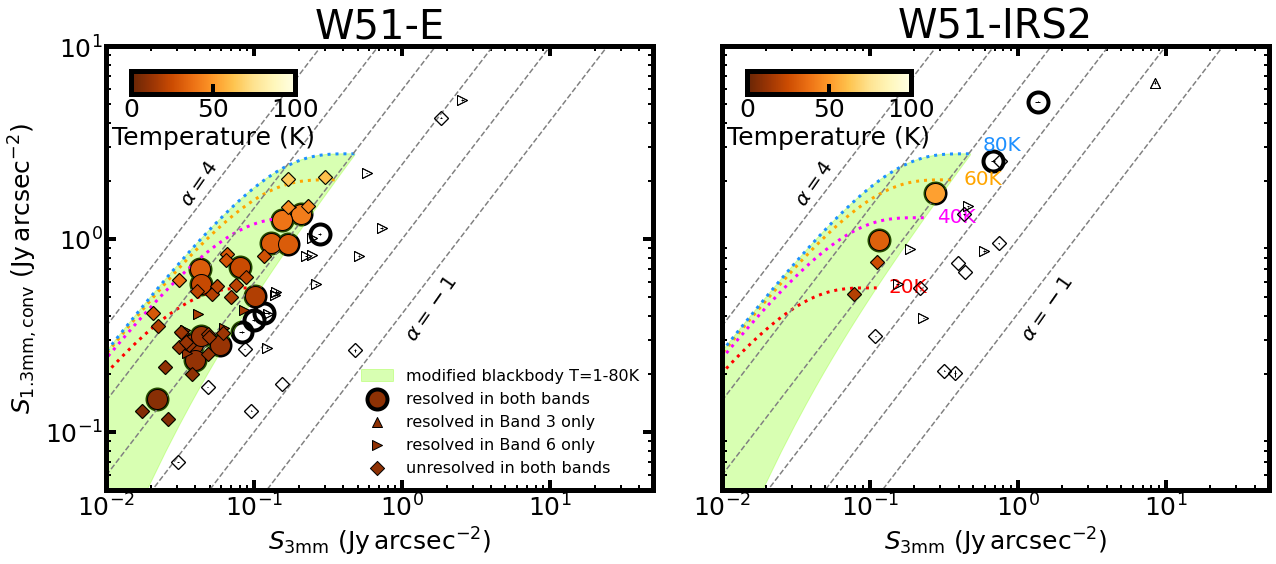

In [6]:
import seaborn as sns
import matplotlib
import matplotlib.cm as cm
from scipy.interpolate import CubicSpline

temp_yso_arr_w51e = np.array(temp_yso_arr_w51e)
temp_yso_arr_w51n = np.array(temp_yso_arr_w51n)
print(temp_yso_arr_w51e)
#temp_yso_arr_w51e[temp_yso_arr_w51e>500]=np.nan
#temp_yso_arr_w51n[temp_yso_arr_w51n>500]=np.nan

#nonan_w51e = np.where(np.isfinite(temp_yso_arr_w51e))
#nonan_w51n = np.where(np.isfinite(temp_yso_arr_w51n))

#nan_w51e = np.where(~np.isfinite(temp_yso_arr_w51e))
#nan_w51n = np.where(~np.isfinite(temp_yso_arr_w51n))


"""
w51e_b3_flux_rescaled_err_nonan = np.array(list(zip(w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e],
                                              w51e_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e])))
w51e_b3_flux_rescaled_err_nonan = np.array([[w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e]
                                             ,w51e_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51e]]]).T

w51e_b6_flux_rescaled_err_nonan = np.array(list(zip(w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e],
                                              w51e_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]))).T
w51e_b6_flux_rescaled_err_nonan = np.array([[w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51e]
                                             ,w51e_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51e]-w51e_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51e]]]).T

w51n_b3_flux_rescaled_err_nonan = np.array(list(zip(w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n],
                                              w51n_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]))).T
w51n_b3_flux_rescaled_err_nonan = np.array([[w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n]
                                             ,w51n_b3_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b3_flux_rescaled_int.to(u.Jy).value[nonan_w51n]]]).T
w51n_b6_flux_rescaled_err_nonan = np.array(list(zip(w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n],
                                              w51n_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]))).T
w51n_b6_flux_rescaled_err_nonan = np.array([[w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_low_rescaled_int.to(u.Jy).value[nonan_w51n]
                                             ,w51n_b6_flux_upp_rescaled_int.to(u.Jy).value[nonan_w51n]-w51n_b6_flux_rescaled_int.to(u.Jy).value[nonan_w51n]]]).T


w51e_b3_flux_rescaled_err_nan = np.array(list(zip(w51e_b3_flux_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b3_flux_low_rescaled_int.to(u.Jy).value[nan_w51e],
                                              w51e_b3_flux_upp_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b3_flux_rescaled_int.to(u.Jy).value[nan_w51e]))).T

w51e_b6_flux_rescaled_err_nan = np.array(list(zip(w51e_b6_flux_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b6_flux_low_rescaled_int.to(u.Jy).value[nan_w51e],
                                              w51e_b6_flux_upp_rescaled_int.to(u.Jy).value[nan_w51e]-w51e_b6_flux_rescaled_int.to(u.Jy).value[nan_w51e]))).T

w51n_b3_flux_rescaled_err_nan = np.array(list(zip(w51n_b3_flux_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b3_flux_low_rescaled_int.to(u.Jy).value[nan_w51n],
                                              w51n_b3_flux_upp_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b3_flux_rescaled_int.to(u.Jy).value[nan_w51n]))).T

w51n_b6_flux_rescaled_err_nan = np.array(list(zip(w51n_b6_flux_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b6_flux_low_rescaled_int.to(u.Jy).value[nan_w51n],
                                              w51n_b6_flux_upp_rescaled_int.to(u.Jy).value[nan_w51n]-w51n_b6_flux_rescaled_int.to(u.Jy).value[nan_w51n]))).T
"""
cmap = sns.color_palette("YlOrBr_r", as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=0, vmax=100, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
color_w51e = np.array([(mapper.to_rgba(v)) for v in temp_yso_arr_w51e])
color_w51n = np.array([(mapper.to_rgba(v)) for v in temp_yso_arr_w51n])

fig = plt.figure(figsize=(19,8))
ax1 = fig.add_axes([0.1,0.15,0.4,0.77])
ax2 = fig.add_axes([0.55,0.15,0.4,0.77])

sc=ax1.scatter(w51e_b3_flux_rescaled_int.to(u.Jy).value, w51e_b6_flux_rescaled_int.to(u.Jy).value,s=0,
              c=temp_yso_arr_w51e,vmin=0,vmax=100,cmap=cmap)

def plot_flux_flux_temp(ax, b3flux, b6flux, b3fluxerr, b6fluxerr, color, idxlist, lws=[4,1,1,1],
                        label='W51-E', markerlist=['o','^', '>', 'D'], sizelist=[20,10,10,10], uplimarr=[False,True,True, True], lolimarr=[False,False,True,True]):
    for idx, marker, size, uplim, lolim, lw in zip(idxlist, markerlist, sizelist, uplimarr, lolimarr, lws):
        for x, y, xerr, yerr, c,  in zip(b3flux[idx], 
                                    b6flux[idx],
                                    b3fluxerr[idx],
                                    b6fluxerr[idx],
                                    color[idx], 
                                   ):
            ax.errorbar(x,y, 
                    xerr=xerr, 
                    yerr=yerr,
                    fmt=marker, c=c, 
                    ecolor='k', elinewidth=1, mec='k',ms=size,zorder=50)
            ax.scatter(x,y, edgecolor='k',lw=lw, marker=marker,zorder=0,s=size**2,c=c)

idxlist_w51e = [w51e_b3_res_b6_res, w51e_b3_res_b6_unres, w51e_b3_unres_b6_res , w51e_b3_unres_b6_unres   ]

plot_flux_flux_temp(ax1, w51e_b3_flux_rescaled_int.to(u.Jy).value, w51e_b6_flux_rescaled_int.to(u.Jy).value, 
                    w51e_b3_flux_err_rescaled_int, w51e_b3_flux_err_rescaled_int, color_w51e, idxlist_w51e,
                        label='W51-E',)
idxlist_w51n = [w51n_b3_res_b6_res, w51n_b3_res_b6_unres, w51n_b3_unres_b6_res , w51n_b3_unres_b6_unres   ]
    
plot_flux_flux_temp(ax2, w51n_b3_flux_rescaled_int.to(u.Jy).value, w51n_b6_flux_rescaled_int.to(u.Jy).value, 
                    w51n_b3_flux_err_rescaled_int, w51n_b3_flux_err_rescaled_int, color_w51n, idxlist_w51n,
                        label='W51-IRS2',)

axins1 = inset_axes(
    ax1,
    width="30%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper left", borderpad=2.5
    )
axins1.xaxis.set_ticks_position("bottom")
axcbr = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[0, 50, 100])
axcbr.set_label('Temperature (K)')
axins2 = inset_axes(
    ax2,
    width="30%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper left",borderpad=2.5
    )
axins2.xaxis.set_ticks_position("bottom")
axcbr = fig.colorbar(sc, cax=axins2, orientation="horizontal", ticks=[0, 50, 100])
axcbr.set_label('Temperature (K)')

"""
b3freq = 92982346121.91989 
b6freq = 226691598706.70853
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=14,c='gray')

ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=14,c='gray')
"""
b3flux_1 = get_bb_intensity(freq93, surf_den, 1*u.K)
b6flux_1 = get_bb_intensity(freq225, surf_den, 1*u.K)

b3flux_lowlimit_curve_over1 = get_bb_intensity(freq93, surf_den[-1], np.arange(2,80,1)*u.K)
b6flux_lowlimit_curve_over1 = get_bb_intensity(freq225, surf_den[-1], np.arange(2,80,1)*u.K)
b3flux_lowlimit_curve = np.concatenate((b3flux_1.value, b3flux_lowlimit_curve_over1.value))
b6flux_lowlimit_curve = np.concatenate((b6flux_1.value, b6flux_lowlimit_curve_over1.value))
b3flux_80 = get_bb_intensity(freq93, surf_den, 80*u.K)
b6flux_80 = get_bb_intensity(freq225, surf_den, 80*u.K)

interp = CubicSpline(b3flux_80.value, b6flux_80.value)

ax1.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3,label='modified blackbody T=1-80K')
ax2.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3)


b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K)
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)

b3flux_40 = get_bb_intensity(freq93, surf_den, 40*u.K)
b6flux_40 = get_bb_intensity(freq225, surf_den, 40*u.K)

b3flux_60 = get_bb_intensity(freq93, surf_den, 60*u.K)
b6flux_60 = get_bb_intensity(freq225, surf_den, 60*u.K)

b3flux_80 = get_bb_intensity(freq93, surf_den, 80*u.K)
b6flux_80 = get_bb_intensity(freq225, surf_den, 80*u.K)

ax1.plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
ax1.plot(b3flux_40, b6flux_40, c='magenta', ls='dotted',lw=3)
ax1.plot(b3flux_60, b6flux_60, c='orange', ls='dotted',lw=3)
ax1.plot(b3flux_80, b6flux_80, c='dodgerblue', ls='dotted',lw=3)

ax2.plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
ax2.plot(b3flux_40, b6flux_40, c='magenta', ls='dotted',lw=3)
ax2.plot(b3flux_60, b6flux_60, c='orange', ls='dotted',lw=3)
ax2.plot(b3flux_80, b6flux_80, c='dodgerblue', ls='dotted',lw=3)
ax2.text(1.2*b3flux_20[-1].value,0.95*b6flux_20[-1].value, '20K', fontsize=20,color='r')
ax2.text(1.2*b3flux_40[-1].value,0.95*b6flux_40[-1].value, '40K', fontsize=20,color='magenta')

ax2.text(1.2*b3flux_60[-1].value,0.95*b6flux_60[-1].value, '60K', fontsize=20,color='orange')
ax2.text(1.2*b3flux_80[-1].value,1.05*b6flux_80[-1].value, '80K', fontsize=20,color='dodgerblue')

#ax1.text(1.5e-3,7e-3,r'$T=100\,{\rm K}$',c='dodgerblue',fontsize=13)
#ax1.text(8e-4,3.5e-3,r'$T=50\,{\rm K}$',c='magenta',fontsize=13)
#ax1.text(3e-4,1e-3,r'$T=20\,{\rm K}$',c='r',fontsize=13)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$S_{\rm 3mm}$ $({\rm Jy\,arcsec^{-2}})$')
ax1.set_ylabel(r'$S_{\rm 1.3mm, conv}$ $({\rm Jy\,arcsec^{-2}})$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$S_{\rm 3mm}$ $({\rm Jy\,arcsec^{-2}})$')
#ax2.set_ylabel(r'$S_{\rm int, 1.3mm}$ (Jy)')

ax1.set_title('W51-E', fontsize=40)
ax2.set_title('W51-IRS2', fontsize=40)
ax1.set_xlim(1e-2,5e1)
ax1.set_ylim(5e-2,1e1)
ax2.set_xlim(1e-2,5e1)
ax2.set_ylim(5e-2,1e1)

#ax1.set_xlim(1e9,1e13)
#ax1.set_ylim(1e10,5e12)
#ax2.set_xlim(1e9,1e13)
#ax2.set_ylim(1e10,5e12)
ax2.set_yticks([])
b3freq = 92982346121.91989 
b6freq = 226691598706.70853
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-2,1e2],10**(np.log10([1e-2,1e2]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')
    ax2.plot([1e-2,1e2],10**(np.log10([1e-2,1e2]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')

ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=20**2, lw=4, marker='o',label='resolved in both bands',edgecolor='k')
ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=10**2, lw=1, marker='^',label='resolved in Band 3 only',edgecolor='k') 
ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=10**2, lw=1, marker='>',label='resolved in Band 6 only',edgecolor='k') 
ax1.scatter([-1,-1],[-1,-1], c=mapper.to_rgba(10), s=10**2, lw=1, marker='D',label='unresolved in both bands',edgecolor='k') 

ax1.legend(fontsize=16, frameon=False, loc='lower right')
    
    

ax1.text(0.03,1.5,r'$\alpha=4$',rotation=55,fontsize=20)
ax1.text(1,0.3,r'$\alpha=-1$',rotation=55,fontsize=20)
ax2.text(0.03,1.5,r'$\alpha=4$',rotation=55,fontsize=20)
ax2.text(1,0.3,r'$\alpha=-1$',rotation=55,fontsize=20)
plt.savefig('fluxflux_temp.png')

22.443219160955838 32.17958965168274
22.443219160955838 32.17958965168274
18.539967405346104 28.894250538675102
41
128 48 74 4


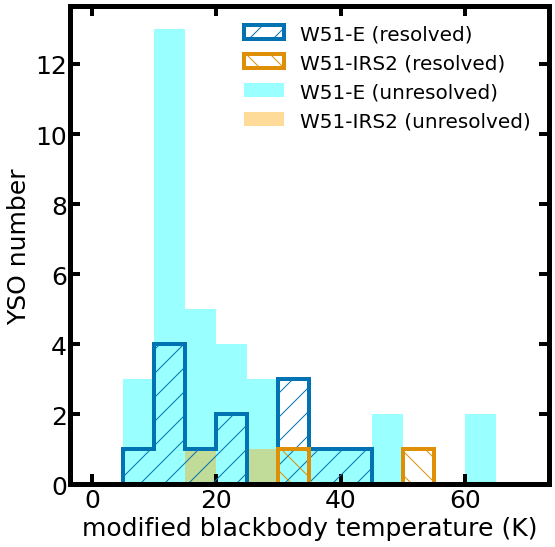

In [7]:
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_axes([0.15,0.15,0.83,0.83])
tempbin = np.linspace(0,70,15)
ax3.hist(temp_yso_arr_w51e[w51e_b3_res_b6_res], bins=tempbin,  histtype='step', color=sns.color_palette('colorblind')[0], label='W51-E (resolved)',lw=4, hatch='/')
ax3.hist(temp_yso_arr_w51n[w51n_b3_res_b6_res], bins=tempbin,  histtype='step',color=sns.color_palette('colorblind')[1], label='W51-IRS2 (resolved)',hatch='\\',lw=4)

unresolveds_w51e = np.logical_or(np.logical_or(w51e_b3_res_b6_unres, w51e_b3_unres_b6_res), w51e_b3_unres_b6_unres)
unresolveds_w51n = np.logical_or(np.logical_or(w51n_b3_res_b6_unres, w51n_b3_unres_b6_res), w51n_b3_unres_b6_unres)
ax3.hist(temp_yso_arr_w51e[unresolveds_w51e], bins=tempbin,   facecolor='cyan', alpha=0.4,label='W51-E (unresolved)')
ax3.hist(temp_yso_arr_w51n[unresolveds_w51n], bins=tempbin,  facecolor='orange', alpha=0.4,label='W51-IRS2 (unresolved)')

print(np.nanmean(temp_yso_arr_w51e), np.nanmean(temp_yso_arr_w51n))
print(np.nanmean(temp_yso_arr_w51e), np.nanmean(temp_yso_arr_w51n))
print(np.nanmedian(temp_yso_arr_w51e), np.nanmedian(temp_yso_arr_w51n))

print(np.nanargmax(w51e_b3_flux_rescaled_int.to(u.Jy).value))
print(len(temp_yso_arr_w51e), len(np.where(np.isfinite(temp_yso_arr_w51e))[0]), len(temp_yso_arr_w51n),len(np.where(np.isfinite(temp_yso_arr_w51n))[0]))
ax3.legend(fontsize=20, frameon=False)
ax3.set_xlabel('modified blackbody temperature (K)')
ax3.set_ylabel('YSO number')
#ax3.set_yticks([5,10,15])

plt.savefig('temp_hist.png')

In [8]:
w51e_catalog['temp']=temp_yso_arr_w51e
w51n_catalog['temp']=temp_yso_arr_w51n
w51e_catalog.write(Path.w51e_dendro_matched_catalog,overwrite=True, format='fits')
w51n_catalog.write(Path.w51n_dendro_matched_catalog,overwrite=True, format='fits')

In [9]:
w51e_b3_major = w51e_b3_flux_fits['deconvolved_major']
w51e_b6_major = w51e_b6_flux_conv_fits['deconvolved_major']
w51n_b3_major = w51n_b3_flux_fits['deconvolved_major']
w51n_b6_major = w51n_b6_flux_conv_fits['deconvolved_major']
w51e_b3_minor = w51e_b3_flux_fits['deconvolved_minor']
w51e_b6_minor = w51e_b6_flux_conv_fits['deconvolved_minor']
w51n_b3_minor = w51n_b3_flux_fits['deconvolved_minor']
w51n_b6_minor = w51n_b6_flux_conv_fits['deconvolved_minor']

w51e_b3_major_upperr = w51e_b3_flux_fits['deconvolved_major_upperr']
w51e_b6_major_upperr = w51e_b6_flux_conv_fits['deconvolved_major_upperr']
w51n_b3_major_upperr = w51n_b3_flux_fits['deconvolved_major_upperr']
w51n_b6_major_upperr = w51n_b6_flux_conv_fits['deconvolved_major_upperr']
w51e_b3_minor_upperr = w51e_b3_flux_fits['deconvolved_minor_upperr']
w51e_b6_minor_upperr = w51e_b6_flux_conv_fits['deconvolved_minor_upperr']
w51n_b3_minor_upperr = w51n_b3_flux_fits['deconvolved_minor_upperr']
w51n_b6_minor_upperr = w51n_b6_flux_conv_fits['deconvolved_minor_upperr']

w51e_b3_major_lowerr = w51e_b3_flux_fits['deconvolved_major_lowerr']
w51e_b6_major_lowerr = w51e_b6_flux_conv_fits['deconvolved_major_lowerr']
w51n_b3_major_lowerr = w51n_b3_flux_fits['deconvolved_major_lowerr']
w51n_b6_major_lowerr = w51n_b6_flux_conv_fits['deconvolved_major_lowerr']
w51e_b3_minor_lowerr = w51e_b3_flux_fits['deconvolved_minor_lowerr']
w51e_b6_minor_lowerr = w51e_b6_flux_conv_fits['deconvolved_minor_lowerr']
w51n_b3_minor_lowerr = w51n_b3_flux_fits['deconvolved_minor_lowerr']
w51n_b6_minor_lowerr = w51n_b6_flux_conv_fits['deconvolved_minor_lowerr']


w51e_b3_int_fluxlow = w51e_b3_flux_fits['flux_lowerr']
w51e_b6_int_fluxlow = w51e_b6_flux_conv_fits['flux_lowerr']
w51n_b3_int_fluxlow = w51n_b3_flux_fits['flux_lowerr']
w51n_b6_int_fluxlow = w51n_b6_flux_conv_fits['flux_lowerr']

w51e_b3_int_fluxupp = w51e_b3_flux_fits['flux_upperr']
w51e_b6_int_fluxupp = w51e_b6_flux_conv_fits['flux_upperr']
w51n_b3_int_fluxupp = w51n_b3_flux_fits['flux_upperr']
w51n_b6_int_fluxupp = w51n_b6_flux_conv_fits['flux_upperr']

w51e_b3_int_fluxerr = np.hstack((w51e_b3_int_flux-w51e_b3_int_fluxlow,w51e_b3_int_fluxupp-w51e_b3_int_flux)).T
w51e_b6_int_fluxerr = np.hstack((w51e_b6_int_flux-w51e_b6_int_fluxlow,w51e_b6_int_fluxupp-w51e_b6_int_flux)).T
w51n_b3_int_fluxerr = np.hstack((w51n_b3_int_flux-w51n_b3_int_fluxlow,w51n_b3_int_fluxupp-w51n_b3_int_flux)).T
w51n_b6_int_fluxerr = np.hstack((w51n_b6_int_flux-w51n_b6_int_fluxlow,w51n_b6_int_fluxupp-w51n_b6_int_flux)).T


w51e_b3_avg_size = np.sqrt(w51e_b3_major*w51e_b3_minor) * 2 /2.355 * np.pi/180 * 5.4*1000*206265
w51e_b6_avg_size = np.sqrt(w51e_b6_major*w51e_b6_minor) * 2 /2.355 * np.pi/180 * 5.4*1000*206265
w51n_b3_avg_size = np.sqrt(w51n_b3_major*w51n_b3_minor) * 2 /2.355 * np.pi/180 * 5.4*1000*206265
w51n_b6_avg_size = np.sqrt(w51n_b6_major*w51n_b6_minor) * 2 /2.355 * np.pi/180 * 5.4*1000*206265

temp_yso_arr_w51e = make_temp_hist(w51e_b3_int_flux, w51e_b6_int_flux, w51e_b6_avg_size, surf_den, temparr, freq93, freq225,w51eind2, plot=True )
temp_yso_arr_w51n = make_temp_hist(w51n_b3_int_flux, w51n_b6_int_flux, w51n_b6_avg_size, surf_den, temparr, freq93, freq225 ,w51nind2,plot=True)
w51e_catalog['BBtemp'] = temp_yso_arr_w51e
w51e_catalog.write(w51e_matched_catalog,format='fits',overwrite=True)
w51n_catalog['BBtemp'] = temp_yso_arr_w51n
w51n_catalog.write(w51n_matched_catalog,format='fits',overwrite=True)



KeyError: 'deconvolved_major_upperr'

In [ ]:
def make_temp_hist2(b3flux, b6flux, size, surf_den, temparr, b3freq, b6freq, index, plot=False):
    temp_yso_arr = []
   
    for i in range(len(b3flux)):
        if i in index:
            rad = size[i] #use B3 size because B6 size is measured from the image before convolution
            b6fluxarr = []
            isinsidearr=[]

            for temp in temparr:
                b3flux_bb = get_bb_flux(rad, b3freq, surf_den, temp*u.K)
                b6flux_bb = get_bb_flux(rad, b6freq, surf_den, temp*u.K)
                b3ind = np.searchsorted(b3flux_bb.value, b3flux[i])
                if b3ind==len(surf_den):
                    b3ind = len(surf_den)-1
                    isinsidearr.append(False)
                else:
                    isinsidearr.append(True)
                b6flux_inbetween = b6flux_bb[b3ind].value
                b6fluxarr.append(b6flux_inbetween)


            tempind = np.searchsorted(b6fluxarr, b6flux[i])
            if tempind==len(b6fluxarr):
                tempind = len(b6fluxarr)-1
            if not isinsidearr[tempind]:
                temp_yso=np.nan
            else:
                if tempind>=len(b6fluxarr)-1:
                    weight=0
                else:
                    weight = (b6flux[i] - b6fluxarr[tempind])/(b6fluxarr[tempind+1] - b6fluxarr[tempind])

                temp_yso = temparr[tempind] + weight
        else:
            temp_yso = np.nan
            
        print(b3flux[i], b6flux[i], temp_yso, rad) 
        temp_yso_arr.append(temp_yso)
            
        if plot:
            if not np.isfinite(temp_yso):
                continue
            cmap = plt.get_cmap('viridis')
           

            r_max = size[i]
            b3flux_20 = get_bb_flux(r_max, b3freq, surf_den, 20*u.K)
            b6flux_20 = get_bb_flux(r_max, b6freq, surf_den, 20*u.K)

            b3flux_50 = get_bb_flux(r_max, b3freq, surf_den, 50*u.K)
            b6flux_50 = get_bb_flux(r_max, b6freq, surf_den, 50*u.K)

            b3flux_100 = get_bb_flux(r_max, b3freq, surf_den, 100*u.K)
            b6flux_100 = get_bb_flux(r_max, b6freq, surf_den, 100*u.K)

            b3flux_200 = get_bb_flux(r_max, b3freq, surf_den, 200*u.K)
            b6flux_200 = get_bb_flux(r_max, b6freq, surf_den, 200*u.K)

            axlist[i].plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
            axlist[i].plot(b3flux_50, b6flux_50, c='magenta', ls='dotted',lw=3)
            axlist[i].plot(b3flux_100, b6flux_100, c='peru', ls='dotted',lw=3)
            axlist[i].plot(b3flux_200, b6flux_200, c='dodgerblue', ls='dotted',lw=3)


            plot=ax1.scatter(b3flux[i], b6flux[i],
                             c=temp_yso, vmin=0,vmax=200,cmap=cmap,zorder=50,s=10)



            spectral_indices=[-1,0,1,2,3,4]
            for si in spectral_indices:
                ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')      
            axlist[i].set_xscale('log')
            axlist[i].set_yscale('log')
           
            axlist[i].set_xlim(2e-5,3e-1)
            axlist[i].set_ylim(1e-4,3e0)
            
            axlist[i].text(1e-3,0.3, "T=%d K"%temp_yso,fontsize=20)


            





In [ ]:
fig = plt.figure(figsize=(17,8))
ax1 = fig.add_axes([0.12,0.15,0.38,0.8])
ax2 = fig.add_axes([0.58,0.15,0.38,0.8])

w51eind2 = np.where((w51e_peak_flux_b3>3*w51e_b3_err)&(w51e_peak_flux_b6>3*w51e_b6_err)&(w51e_b6_avg_size >0))[0]
w51nind2 = np.where((w51n_peak_flux_b3>3*w51n_b3_err)&(w51n_peak_flux_b6>3*w51n_b6_err)&(w51n_b6_avg_size >0))[0]


ax1.errorbar(w51e_b3_int_flux[w51eind], w51e_b6_int_flux[w51eind], xerr=w51e_b3_int_fluxerr[w51eind], yerr=w51e_b6_int_fluxerr[w51eind],fmt='o',c='b', label='W51-E')
ax1.errorbar(w51n_b3_int_flux[w51nind], w51n_b6_int_flux[w51nind], xerr=w51n_b3_int_fluxerr[w51nind], yerr=w51n_b6_int_fluxerr[w51nind],fmt='o',c='orange', label='W51-IRS2')

b3freq = 92982346121.91989 
b6freq = 226691598706.70853
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=14,c='gray')

ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=14,c='gray')
ax1.plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
ax1.plot(b3flux_50, b6flux_50, c='magenta', ls='dotted',lw=3)
ax1.plot(b3flux_100, b6flux_100, c='dodgerblue', ls='dotted',lw=3)
ax1.text(1.5e-3,7e-3,r'$T=100\,{\rm K}$',c='dodgerblue',fontsize=13)
ax1.text(8e-4,3.5e-3,r'$T=50\,{\rm K}$',c='magenta',fontsize=13)
ax1.text(3e-4,1e-3,r'$T=20\,{\rm K}$',c='r',fontsize=13)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$F_{\rm int, B3}$ (Jy)')
ax1.set_ylabel(r'$F_{\rm int, B6}$ (Jy)')
ax1.set_xlim(2e-5,3e-1)
ax1.set_ylim(1e-4,3e0)
ax1.legend(fontsize=14)
tempbin = np.arange(0,550,step=50)
ax2.hist(temp_yso_arr_w51e, bins=tempbin, facecolor='none',edgecolor='b', histtype='step',label='W51-E matched',lw=4)
ax2.hist(temp_yso_arr_w51n, bins=tempbin, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 matched',lw=4)
ax2.set_xlabel('dust temperature (K)')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=14)
plt.savefig('flux_flux.png')


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig = plt.figure(figsize=(9,9))
ax1 = fig.add_axes([0.12,0.12,0.8,0.8])

w51eind2 = np.where((w51e_peak_flux_b3>3*w51e_b3_err)&(w51e_peak_flux_b6>3*w51e_b6_err)&(w51e_b6_avg_size >0))[0]
w51nind2 = np.where((w51n_peak_flux_b3>3*w51n_b3_err)&(w51n_peak_flux_b6>3*w51n_b6_err)&(w51n_b6_avg_size >0))[0]

#temp_yso_arr_w51e = make_temp_hist(w51e_b3_int_flux[w51eind2], w51e_b6_int_flux[w51eind2], w51e_b6_avg_size[w51eind2], surf_den, temparr, freq93, freq225 )
#temp_yso_arr_w51n = make_temp_hist(w51n_b3_int_flux[w51nind2], w51n_b6_int_flux[w51nind2], w51n_b6_avg_size[w51nind2], surf_den, temparr, freq93, freq225 )

cmap = plt.get_cmap('viridis')

temp_w51e_ind = np.where((np.array(temp_yso_arr_w51e)<4000)&np.isfinite(temp_yso_arr_w51e))[0]

temp_w51n_ind = np.where((np.array(temp_yso_arr_w51n)<4000)&np.isfinite(temp_yso_arr_w51n))[0]
ax1.errorbar(w51e_b3_int_flux[w51eind][temp_w51e_ind], w51e_b6_int_flux[w51eind][temp_w51e_ind], xerr=w51e_b3_int_fluxerr[w51eind][temp_w51e_ind], 
             yerr=w51e_b6_int_fluxerr[w51eind][temp_w51e_ind],fmt='o',c='k', label='W51-E')
ax1.errorbar(w51n_b3_int_flux[w51nind][temp_w51n_ind], w51n_b6_int_flux[w51nind][temp_w51n_ind], xerr=w51n_b3_int_fluxerr[w51nind][temp_w51n_ind]
             , yerr=w51n_b6_int_fluxerr[w51nind][temp_w51n_ind],fmt='o',c='k', label='W51-IRS2')
plot=ax1.scatter(w51e_b3_int_flux[w51eind][temp_w51e_ind], w51e_b6_int_flux[w51eind][temp_w51e_ind], c=np.array(temp_yso_arr_w51e)[temp_w51e_ind], vmin=0,vmax=200,cmap=cmap,zorder=50)
ax1.scatter(w51n_b3_int_flux[w51nind][temp_w51n_ind], w51n_b6_int_flux[w51nind][temp_w51n_ind], c=np.array(temp_yso_arr_w51n)[temp_w51n_ind], vmin=0,vmax=200,cmap=cmap,zorder=50)

temp_w51e_ind = np.where((np.array(temp_yso_arr_w51e)>4000)&np.isfinite(temp_yso_arr_w51e))[0]
temp_w51n_ind = np.where((np.array(temp_yso_arr_w51n)>4000)&np.isfinite(temp_yso_arr_w51n))[0]
ax1.errorbar(w51e_b3_int_flux[w51eind][temp_w51e_ind], w51e_b6_int_flux[w51eind][temp_w51e_ind], xerr=w51e_b3_int_fluxerr[w51eind][temp_w51e_ind], 
             yerr=w51e_b6_int_fluxerr[w51eind][temp_w51e_ind],fmt='o',c='r', label='W51-E')
ax1.errorbar(w51n_b3_int_flux[w51nind][temp_w51n_ind], w51n_b6_int_flux[w51nind][temp_w51n_ind], xerr=w51n_b3_int_fluxerr[w51nind][temp_w51n_ind]
             , yerr=w51n_b6_int_fluxerr[w51nind][temp_w51n_ind],fmt='o',c='r', label='W51-IRS2')

temp_w51e_ind = np.where(~np.isfinite(temp_yso_arr_w51e))[0]
temp_w51n_ind = np.where(~np.isfinite(temp_yso_arr_w51n))[0]
ax1.errorbar(w51e_b3_int_flux[w51eind][temp_w51e_ind], w51e_b6_int_flux[w51eind][temp_w51e_ind], xerr=w51e_b3_int_fluxerr[w51eind][temp_w51e_ind], 
             yerr=w51e_b6_int_fluxerr[w51eind][temp_w51e_ind],fmt='o',c='gray', label='W51-E')
ax1.errorbar(w51n_b3_int_flux[w51nind][temp_w51n_ind], w51n_b6_int_flux[w51nind][temp_w51n_ind], xerr=w51n_b3_int_fluxerr[w51nind][temp_w51n_ind]
             , yerr=w51n_b6_int_fluxerr[w51nind][temp_w51n_ind],fmt='o',c='gray', label='W51-IRS2')

axins1 = inset_axes(
    ax1,
    width="50%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper center",
)
axins1.xaxis.set_ticks_position("bottom")
axcbr = fig.colorbar(plot, cax=axins1, orientation="horizontal", ticks=[0, 100, 200,300,400,500])
axcbr.set_label('temperature (K)')

b3freq = 92982346121.91989 
b6freq = 226691598706.70853
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=14,c='gray')

ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=14,c='gray')


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$F_{\rm int, B3}$ (Jy)')
ax1.set_ylabel(r'$F_{\rm int, B6}$ (Jy)')
ax1.set_xlim(2e-5,3e-1)
ax1.set_ylim(1e-4,3e0)

plt.savefig('flux_flux.png')


In [ ]:
temp_w51e_ind = np.where((np.array(temp_yso_arr_w51e)<4000)&np.isfinite(temp_yso_arr_w51e))[0]

for i in range(len(temp_w51e_ind)):
    fig = plt.figure(figsize=(9,9))
    ax1 = fig.add_axes([0.12,0.12,0.8,0.8])

    r_max = w51e_b6_avg_size[w51eind][temp_w51e_ind][i]
    b3flux_20 = get_bb_flux(r_max, freq93, surf_den, 20*u.K)
    b6flux_20 = get_bb_flux(r_max, freq225, surf_den, 20*u.K)

    b3flux_50 = get_bb_flux(r_max, freq93, surf_den, 50*u.K)
    b6flux_50 = get_bb_flux(r_max, freq225, surf_den, 50*u.K)

    b3flux_100 = get_bb_flux(r_max, freq93, surf_den, 100*u.K)
    b6flux_100 = get_bb_flux(r_max, freq225, surf_den, 100*u.K)
    
    b3flux_200 = get_bb_flux(r_max, freq93, surf_den, 200*u.K)
    b6flux_200 = get_bb_flux(r_max, freq225, surf_den, 200*u.K)
    
    ax1.plot(b3flux_20, b6flux_20, c='r', ls='dotted',lw=3)
    ax1.plot(b3flux_50, b6flux_50, c='magenta', ls='dotted',lw=3)
    ax1.plot(b3flux_100, b6flux_100, c='peru', ls='dotted',lw=3)
    ax1.plot(b3flux_200, b6flux_200, c='dodgerblue', ls='dotted',lw=3)
    
    ax1.errorbar(w51e_b3_int_flux[w51eind2][temp_w51e_ind][i], w51e_b6_int_flux[w51eind2][temp_w51e_ind][i], 
                 xerr=w51e_b3_int_fluxerr[w51eind2][i], yerr=w51e_b6_int_fluxerr[w51eind2][temp_w51e_ind][i],
                 fmt='o',c='b', label='W51-E')
    plot=ax1.scatter(w51e_b3_int_flux[w51eind2][temp_w51e_ind][i], w51e_b6_int_flux[w51eind2][temp_w51e_ind][i],
                     c=np.array(temp_yso_arr_w51e)[temp_w51e_ind][i], vmin=0,vmax=200,cmap=cmap,zorder=50)

    print(w51e_b3_int_flux[w51eind2][temp_w51e_ind][i], w51e_b6_int_flux[w51eind2][temp_w51e_ind][i]
          , r_max, np.array(temp_yso_arr_w51e)[temp_w51e_ind][i]) 
    
    
    axins1 = inset_axes(
    ax1,
    width="50%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper center",
    )
    axins1.xaxis.set_ticks_position("bottom")
    axcbr = fig.colorbar(plot, cax=axins1, orientation="horizontal", ticks=[0, 100, 200])
    b3freq = 92982346121.91989 
    b6freq = 226691598706.70853
    spectral_indices=[-1,0,1,2,3,4]
    for si in spectral_indices:
        ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed')      
    axcbr.set_label('temperature (K)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'$F_{\rm int, B3}$ (Jy)')
    ax1.set_ylabel(r'$F_{\rm int, B6}$ (Jy)')
    ax1.set_xlim(2e-5,3e-1)
    ax1.set_ylim(1e-4,3e0)
    
    
    plt.show()
    plt.close()

In [ ]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_axes([0.12,0.12,0.8,0.8])

ax1.scatter(w51e_b6_avg_size[w51eind2],temp_yso_arr_w51e, s=10, c='b')
ax1.scatter(w51n_b6_avg_size[w51nind2],temp_yso_arr_w51n, s=10, c='orange')
ax1.set_xlim(0,2000)
ax1.set_ylim(0,600)


In [ ]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_axes([0.12,0.15,0.35,0.8])
ax2 = fig.add_axes([0.6,0.15,0.35,0.8])

ax1.plot([5e-5,1e0],[5e-5,1e0], ls='dashed',lw=3,c='k')
ax2.plot([5e-4,3e0],[5e-4,3e0], ls='dashed',lw=3,c='k')

ax1.errorbar( w51e_peak_flux_b3[w51eind],w51e_b3_int_flux[w51eind], xerr=w51e_b3_int_fluxerr[w51eind], yerr=w51e_b3_err,fmt='o',c='b', label='W51-E')
ax1.errorbar( w51n_peak_flux_b3[w51eind],w51n_b3_int_flux[w51eind], xerr=w51n_b3_int_fluxerr[w51eind], yerr=w51n_b3_err,fmt='o',c='orange', label='W51-IRS2')


ax2.errorbar( w51e_peak_flux_b6[w51eind],w51e_b6_int_flux[w51eind], xerr=w51e_b6_int_fluxerr[w51eind], yerr=w51e_b6_err,fmt='o',c='b', label='W51-E')
ax2.errorbar( w51n_peak_flux_b6[w51eind],w51n_b6_int_flux[w51eind], xerr=w51n_b6_int_fluxerr[w51eind], yerr=w51n_b6_err,fmt='o',c='orange', label='W51-IRS2')


ax1.set_xlabel(r'$F_{\rm peak, B3} (Jy)$')
ax1.set_ylabel(r'$F_{\rm int, B3} (Jy)$')
ax2.set_xlabel(r'$F_{\rm peak, B6} (Jy)$')
ax2.set_ylabel(r'$F_{\rm int, B6} (Jy)$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)


In [ ]:





w51e_b3_avg_size = np.sqrt(w51e_b3_major * w51e_b3_minor) * np.pi/180 * 5.41*1000*206265
w51e_b6_avg_size = np.sqrt(w51e_b6_major * w51e_b6_minor)* np.pi/180 * 5.41*1000*206265
w51n_b3_avg_size = np.sqrt(w51n_b3_major * w51n_b3_minor) * np.pi/180 * 5.1*1000*206265
w51n_b6_avg_size = np.sqrt(w51n_b6_major * w51n_b6_minor) * np.pi/180 * 5.1*1000*206265

w51e_b3_flux_ratio = w51e_peak_flux_b3[w51eind]/w51e_b3_int_flux[w51eind]
w51e_b6_flux_ratio = w51e_peak_flux_b6[w51eind]/w51e_b6_int_flux[w51eind]
w51n_b3_flux_ratio = w51n_peak_flux_b3[w51nind]/w51n_b3_int_flux[w51nind]
w51n_b6_flux_ratio = w51n_peak_flux_b6[w51nind]/w51n_b6_int_flux[w51nind]

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_axes([0.12,0.15,0.35,0.8])
ax2 = fig.add_axes([0.6,0.15,0.35,0.8])

ax1.scatter(w51e_b3_avg_size[w51eind],w51e_b3_flux_ratio, c='r', label='B3')
ax1.scatter(w51e_b6_avg_size[w51eind],w51e_b6_flux_ratio, c='b', label='B6')
ax2.scatter(w51n_b3_avg_size[w51nind],w51n_b3_flux_ratio, c='r', label='B3')
ax2.scatter(w51n_b6_avg_size[w51nind],w51n_b6_flux_ratio, c='b', label='B6')

ax1.set_xlabel(r'$FWHM_{\rm dec}$ (AU)')
ax2.set_xlabel(r'$FWHM_{\rm dec}$ (AU)')
ax1.set_ylabel(r'$F_{\rm peak}/F_{\rm int}$')
ax2.set_ylabel(r'$F_{\rm peak}/F_{\rm int}$')
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)
ax1.set_xlim(0,500)
ax2.set_xlim(0,500)